# Brain Tumor Classification with Neural Networks

### Objective
This project aims to develop skills in training neural networks to classify tumors in brain MRI scans. Participants will construct and optimize neural network architectures through techniques like transfer learning and custom convolutional layers. Additionally, the project will incorporate the Gemini 1.5 Flash model to generate interpretable explanations for model predictions, enhancing both accuracy and transparency in tumor classification.

### What is a Brain Tumor?
A brain tumor is a mass of abnormal cells within the brain. Given that the brain is encased in a rigid skull, any growth in this limited space can create pressure, leading to potential complications. Brain tumors may be cancerous (malignant) or noncancerous (benign), and as they grow, they can elevate pressure within the skull, potentially causing brain damage and posing serious health risks.

![tumor.png](attachment:9968c517-fdeb-48b1-a635-0382ca5a0240.png)

* **Glioma**: They can make nearby brain areas look swollen and may have dark spots in the center if the tissue is damaged.
* **Meningioma**: They are appear with well-defined rounded mass growing on the outer layer of the brain (the meninges). These are usually rounded tumors growing on the outer layer of the brain (the meninges). They stand out clearly on scans with smooth, well-defined edges and can appear to "stick" to the lining of the brain.
* **Pituitary**: Located at the base of the brain, these tumors affect the pituitary gland. They generally look uniform and bright on scans, and they can push against nearby areas like the nerves for vision.
* **Normal**: Shows a balanced, symmetrical appearance with no lumps, swelling, or unusual bright spots, indicating no tumors or abnormal growths.

### Why This Matters*
Early detection and accurate classification of brain tumors are vital areas of research in medical imaging. Prompt identification of tumor types allows for the most effective treatment approach, which is critical to improving outcomes and potentially saving patients’ lives.



**Source:**
* [Kaggle Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)
* [Kaggle: CNN Brain Tumor Classification by guslovesmath](https://www.kaggle.com/code/guslovesmath/cnn-brain-tumor-classification-99-accuracy)
* [Kaggle: Brain Tumor MRI Accuracy 99% by yousef mohamed](https://www.kaggle.com/code/yousefmohamed20/brain-tumor-mri-accuracy-99)
* [Youtube: What is neural network](https://www.youtube.com/watch?v=aircAruvnKk)
* [Youtube: How Neural Networks Learn](https://www.youtube.com/watch?v=IHZwWFHWa-w)
* [Youtube: What is a convolution](https://www.youtube.com/watch?v=KuXjwB4LzSA)
* [Interactive CNN Explainer](https://poloclub.github.io/cnn-explainer/)
* [Youtube: How Tesla uses Neural Networks to Power Self Driving](https://www.youtube.com/watch?v=FnFksQo-yEY)
* [What is Transfer Learning](https://builtin.com/data-science/transfer-learning)
* [Medium: Saliency Maps Explanation](https://medium.com/@bijil.subhash/explainable-ai-saliency-maps-89098e230100)
* [Medium: Review on Xception](https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568)
* [Kaggle GradCam++](https://www.kaggle.com/code/tanishqsardana/cam-gradcam-and-gradcam/notebook)
* [Medium Visualization using gradCam](https://medium.com/@tanishqsardana/visualizing-how-cnn-thinks-cam-grad-cam-grad-cam-1dabcf886cc5)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install --upgrade pip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import math
import json


from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Model, Sequential, clone_model, save_model, load_model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
! kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 98% 146M/149M [00:05<00:00, 32.3MB/s]
100% 149M/149M [00:05<00:00, 27.2MB/s]


# Utility functions

In [ ]:
class_dict = {
    0: 'glioma',
    1: 'meningioma',
    2: 'no_tumor',
    3: 'pituitary'
}


def get_class_paths(path):
  classes = []
  class_paths = []

  # Iterate through directories in the training path
  for label in os.scandir(path):
    label_path = os.path.join(path, label)

    # Check if it's a directory
    if os.path.isdir(label_path):
      # Iterate through images in the label directory
      for image in os.listdir(label_path):
        image_path = os.path.join(label_path, image)

        # Add class and path to respective lists
        classes.append(label.name)
        class_paths.append(image_path)

  # Create a DataFrame with the collected data
  df = pd.DataFrame({
      'Class Path': class_paths,
      'Class': classes
  })

  return df




def train_and_save_checkpoints(model, dataset, loss_funcs, epochs=1, learning_rate=0.001, filename='model'):
    """
    Trains the model with specified loss functions and saves checkpoints every 5 epochs.

    Parameters:
    - model: The untrained model architecture.
    - train_images, train_labels: Training data and labels.
    - test_images, test_labels: Validation data and labels.
    - loss_funcs: List of loss functions to evaluate.
    - batch_size: Training batch size.
    - epochs: Total number of epochs to train.
    - learning_rate: Initial learning rate for training.
    - filename: Base filename for saving checkpoints.

    Returns:
    - Dictionary with information about training histories and checkpoints.
    """
    histories = {}
    best_model_info = {
        "loss": float('inf'),
        "accuracy": 0,
        "checkpoint": None,
        "loss_func": None,
        "learning_rate": None
    }

    for loss_func in loss_funcs:
        # Clone the model to reset weights for each loss function
        temp_model = tf.keras.models.clone_model(model)

        # Define the optimizer
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        # Compile the model
        temp_model.compile(
            optimizer=optimizer,
            loss=loss_func,
            metrics=[loss_func, 'accuracy', Precision(), Recall()]
        )

        # Define checkpoint path with epoch formatting
        checkpoint_path = f"/temp/checkpoint/cp-{{epoch:04d}}.model.keras"
        checkpoint_dir = os.path.dirname(checkpoint_path)
        os.makedirs(checkpoint_dir, exist_ok=True)

        # Create a ModelCheckpoint callback to save the model's weights
        cp_callback = ModelCheckpoint(
            filepath=checkpoint_path,
            monitor=['loss'],
            mode='min',
            save_best_only=True,
        )

        # Callback function to update the learning rate every epoch
        lr_callback = LearningRateScheduler(lambda epoch: learning_rate * 10**(epoch / 20))

        # Fit the model with checkpoint and learning rate scheduler callbacks
        history = temp_model.fit(
            dataset,
            epochs=epochs,
            callbacks=[cp_callback, lr_callback],
            verbose=1
        )

        histories[loss_func] = history

        # Find the minimum loss and corresponding learning rate and accuracy
        min_loss_idx = history.history['loss'].index(min(history.history['loss']))
        min_loss = history.history['loss'][min_loss_idx]
        min_lr = history.history['learning_rate'][min_loss_idx]
        best_accuracy = history.history['accuracy'][min_loss_idx]

        # Update optimal model if a new minimum loss or better accuracy in a tie is found
        if (min_loss < best_model_info["loss"]) or (min_loss == best_model_info["loss"] and best_accuracy > best_model_info["accuracy"]):
            best_model_info = {
                "loss": min_loss,
                "accuracy": best_accuracy,
                "checkpoint": checkpoint_path.format(epoch=min_loss_idx),
                "loss_func": loss_func,
                "learning_rate": min_lr
            }

        # Plot the loss vs learning rate for this loss function
        plt.semilogx(history.history['learning_rate'], history.history['loss'], label=f'{loss_func}')

    plt.title('Loss vs Learning Rate')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f'Best Model - Loss: {best_model_info["loss"]}, Accuracy: {best_model_info["accuracy"]}, '
          f'Learning Rate: {best_model_info["learning_rate"]}, Loss Function: {best_model_info["loss_func"]}')

    return {"histories": histories, "best_model_info": best_model_info}

def load_optimal_model(model, best_model_info):
    """
    Loads the model with the lowest loss and best accuracy from the checkpoint.

    Parameters:
    - model: An untrained model instance with the same architecture as the saved model.
    - best_model_info: Dictionary containing the best model checkpoint and other details.

    Returns:
    - best_model: The model loaded with the optimal weights.
    - best_model_info: Information about the best model configuration.
    """
    checkpoint_path = best_model_info["checkpoint"]

    if checkpoint_path:
        # Clone the provided model structure and load the weights
        best_model = clone_model(model)
        best_model.load_weights(checkpoint_path)
        print(f"Model weights loaded from {checkpoint_path}")
        print(f'Best Model - Loss: {best_model_info["loss"]}, Accuracy: {best_model_info["accuracy"]}, '
              f'Learning Rate: {best_model_info["learning_rate"]}, Loss Function: {best_model_info["loss_func"]}')
    else:
        print("No checkpoint path provided.")
        best_model = model  # Return the original model if no path is provided

    return best_model, best_model_info

def save_model_and_history(model, history, filepath):
  keras_file = '/content/' + filepath + ".keras"
  json_file = '/content/history_' + filepath +'.json'

  model.save(keras_file)

  # Save the history to a JSON file
  with open(json_file, 'w') as f:
      json.dump(history, f)

  print(f"Model is saved in {keras_file}, history is saved in {json_file}")

def load_model_and_history_from_file(filepath):
  keras_file = '/content/' + filepath + ".keras"
  json_file = '/content/history_' + filepath +'.json'

  model = load_model(keras_file, compile=True)

  with open(json_file, 'r') as f:
      history = json.load(f)
  return model, history

def display_best_model_history(history):
    metrics = ['loss', 'precision', 'recall', 'accuracy']
    train_metrics = {}
    val_metrics = {}

    for key, val in history.history.items():
        if 'val' in key:
            val_metrics[key.split('_')[1]] = val
        else:
            train_metrics[key.split('_')[0]] = val

    # Find best epochs and values
    best_epochs = {}
    best_values = {}
    for m in metrics:
        if m == 'loss':
            idx = np.argmin(val_metrics[m])
        else:
            idx = np.argmax(val_metrics[m])
        best_epochs[m] = idx + 1
        best_values[m] = val_metrics[m][idx]

    # Plot metrics
    plt.figure(figsize=(20, 12))
    plt.style.use('fivethirtyeight')

    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        epochs = range(1, len(train_metrics[metric]) + 1)

        plt.plot(epochs, train_metrics[metric], 'r', label=f'Training {metric}')
        plt.plot(epochs, val_metrics[metric], 'g', label=f'Validation {metric}')
        plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue', label=f'Best epoch = {best_epochs[metric]}')

        plt.title(f'Training and Validation {metric.title()}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()
        plt.grid(True)

    plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
    plt.show()

def evaluation_report(model, train, valid, test):
  train_score = model.evaluate(train, verbose=1)
  valid_score = model.evaluate(valid, verbose=1)
  test_score = model.evaluate(test, verbose=1)


  print(f'Train Accuracy: {train_score[1]*100:.2f}%')
  print(f'Train Loss: {train_score[0]*100:.4f}%')

  print(f'Validation Accuracy: {valid_score[1]*100:.2f}%')
  print(f'Validation Loss: {valid_score[0]*100:.4f}%')

  print(f'Test Accuracy: {test_score[1]*100:.2f}%')
  print(f'Test Loss: {test_score[0]*100:.4f}%')

def display_confusion_matrix(model, dataset):
  preds = model.predict(dataset)
  y_pred = np.argmax(preds, axis=1)

  # Then create and display the confusion matrix
  cm = confusion_matrix(dataset.classes, y_pred)
  labels = list(class_dict.keys())
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.show()



# Display the MRI image and show the confidence level of prediction
def predict(img_path: str) -> None:
  labels = list(class_dict.keys())

  # Create figure
  plt.figure(figsize=(6, 8))

  # Load and preprocess image
  img = Image.open(img_path)
  resized_img = img.resize((299, 299))
  img_array = np.asarray(resized_img)
  img_array = np.expand_dims(img_array, axis=0) / 255.0

  # Get model predictions
  predictions = model.predict(img_array)
  probabilities = list(predictions[0])

  # Get predicted class
  predicted_class_idx = np.argmax(probabilities)
  predicted_class = class_dict[predicted_class_idx]

  # Plot original image
  plt.subplot(2, 1, 1)
  plt.imshow(resized_img)
  plt.title(f'Input MRI Image\nPredicted: {predicted_class}')

  # Plot prediction probabilities
  plt.subplot(2, 1, 2)
  bars = plt.barh(labels, probabilities)
  plt.xlabel('Probability', fontsize=15)
  plt.title('Class Probabilities')

  # Add probability labels to bars
  ax = plt.gca()
  ax.bar_label(bars, fmt='%.2f')

  plt.tight_layout()
  plt.show

  print(f'\nPredicted tumor type: {predicted_class}')

In [ ]:
train_path = '/content/Training'

train_df = get_class_paths(train_path)
train_df

,Class Path,Class
0,/content/Training/pituitary/Tr-pi_0997.jpg,pituitary
1,/content/Training/pituitary/Tr-pi_1187.jpg,pituitary
2,/content/Training/pituitary/Tr-pi_0578.jpg,pituitary
3,/content/Training/pituitary/Tr-pi_0664.jpg,pituitary
4,/content/Training/pituitary/Tr-pi_1219.jpg,pituitary
...,...,...
5707,/content/Training/notumor/Tr-no_0625.jpg,notumor
5708,/content/Training/notumor/Tr-no_0099.jpg,notumor
5709,/content/Training/notumor/Tr-no_0402.jpg,notumor
5710,/content/Training/notumor/Tr-no_1255.jpg,notumor


In [ ]:

test_path = '/content/Testing'

test_raw_df = get_class_paths(test_path)
test_raw_df

,Class Path,Class
0,/content/Testing/pituitary/Te-pi_0054.jpg,pituitary
1,/content/Testing/pituitary/Te-pi_0100.jpg,pituitary
2,/content/Testing/pituitary/Te-pi_0049.jpg,pituitary
3,/content/Testing/pituitary/Te-pi_0137.jpg,pituitary
4,/content/Testing/pituitary/Te-pi_0232.jpg,pituitary
...,...,...
1306,/content/Testing/notumor/Te-no_0022.jpg,notumor
1307,/content/Testing/notumor/Te-no_0036.jpg,notumor
1308,/content/Testing/notumor/Te-no_0159.jpg,notumor
1309,/content/Testing/notumor/Te-no_0328.jpg,notumor


# Visualization

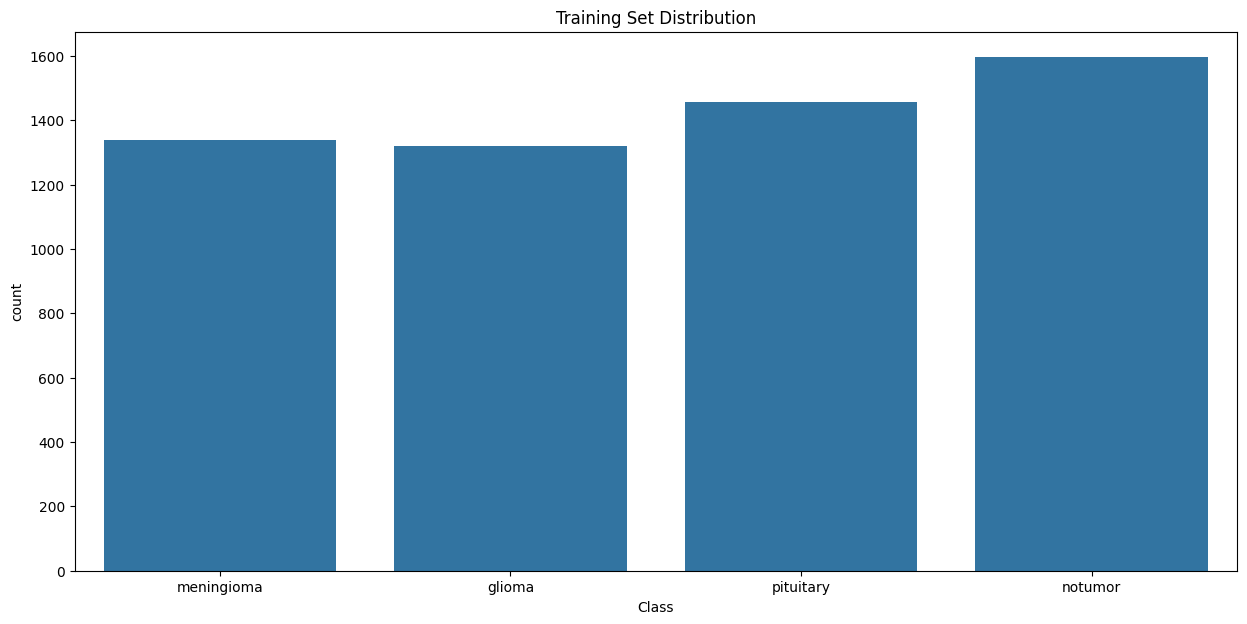

In [ ]:
plt.figure(figsize=(15, 7))
plt.title("Training Set Distribution")
ax = sns.countplot(data=train_df, x=train_df['Class'])

**Observation**: The dataset looks fairly balanced which means that each tumor labels have fair amount of data. This tells us that we don't need to apply sampling techniques

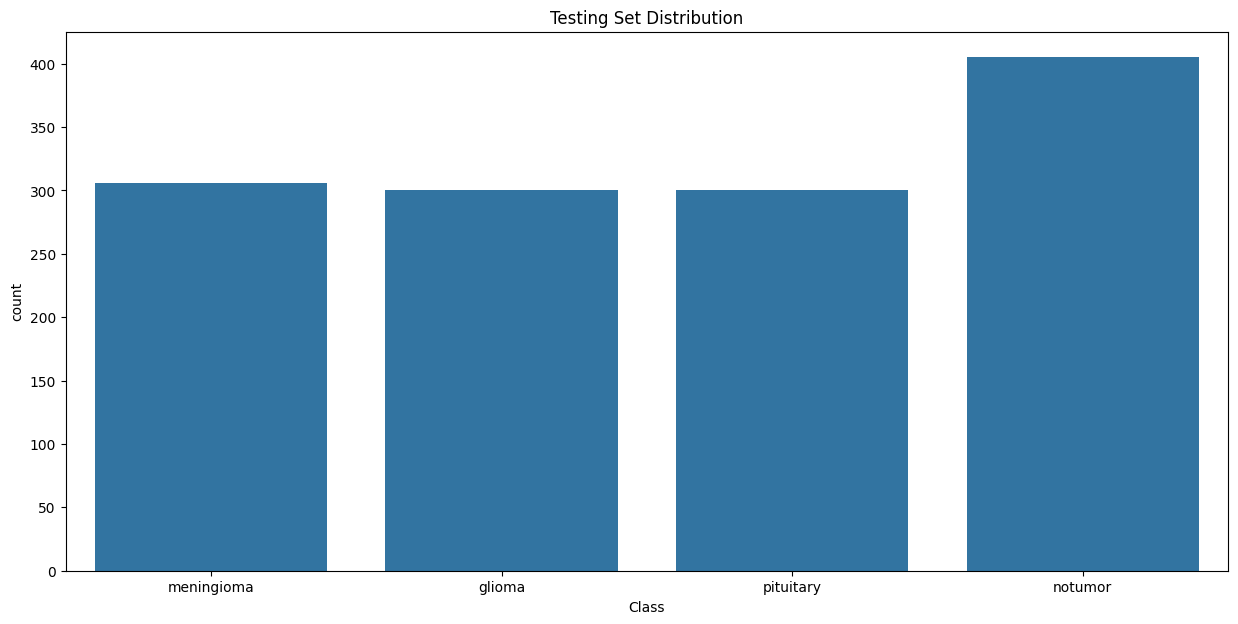

In [ ]:
plt.figure(figsize=(15, 7))
plt.title("Testing Set Distribution")
ax = sns.countplot(data=test_raw_df, x=test_raw_df['Class'])

# Split Data

In [ ]:
valid_df, test_df = train_test_split(test_raw_df, train_size=0.5, stratify=test_raw_df['Class'])
print(valid_df.shape, test_df.shape)

(655, 2) (656, 2)


# Resize Data

NOTE: ImageDataGenerator is deprecated.

# TODO: Update this later. [keras image](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image)

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (299, 299)

image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))
train_img_gen = image_generator.flow_from_dataframe(
    train_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE
  )
valid_img_gen = image_generator.flow_from_dataframe(
    valid_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE
  )

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


In [ ]:
test_image_generator = ImageDataGenerator(rescale=1/255)
test_img_gen = test_image_generator.flow_from_dataframe(
    test_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=16,
    target_size=IMAGE_SIZE,
    shuffle=False
  )

Found 656 validated image filenames belonging to 4 classes.


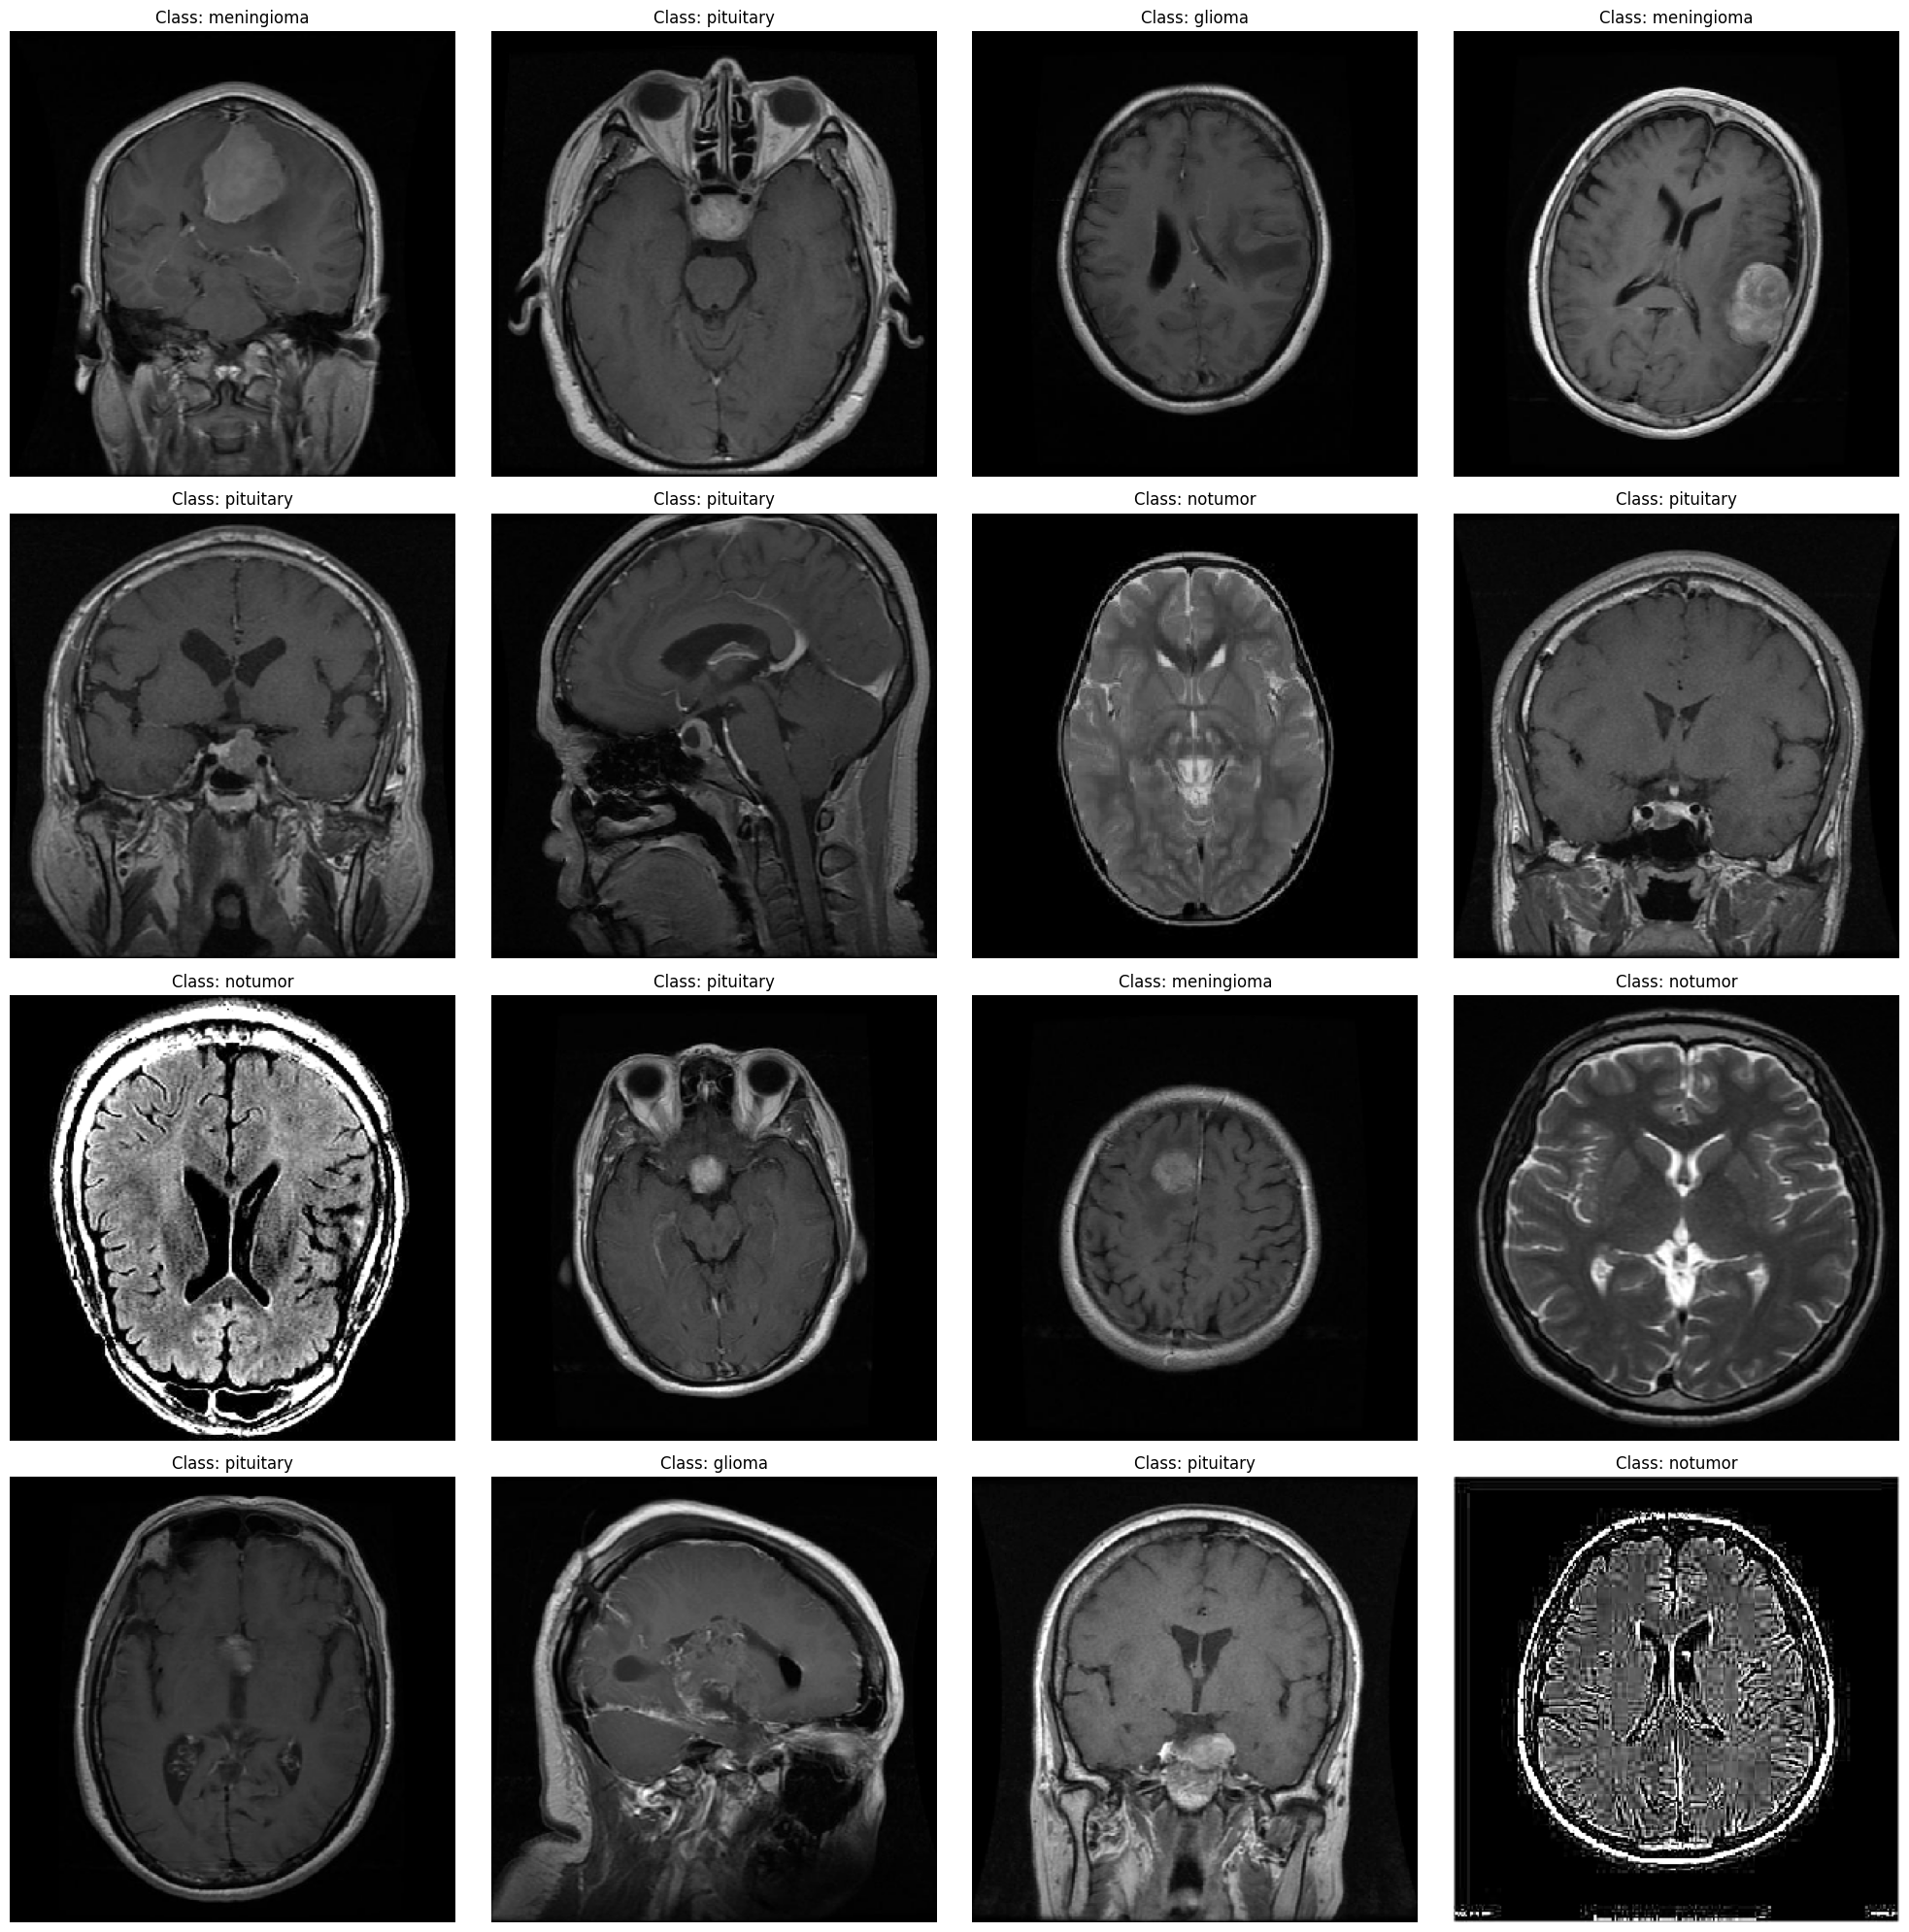

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(16):
  plt.subplot(4, 4, i+1)
  batch = next(train_img_gen)
  image=batch[0][0]
  label = batch[1][0]
  plt.imshow(image)

  # Get the class index
  class_index = np.argmax(label)

  # Get the list of class names and class indices
  class_names = list(train_img_gen.class_indices.keys())
  class_indices = list(train_img_gen.class_indices.values())

  # Find the index of the class_index in the list of indices
  index_position = class_indices.index(class_index)

  # Get the class name using the index position
  class_name = class_names[index_position]

  plt.title(f'Class: {class_name}')
  plt.axis('off')
plt.tight_layout()
plt.show()


## Xception as the basemodel

The model works by breaking down the image into smaller, easier-to-understand parts, and then looks at those parts one by one. Just like if you were to focus on parts of animal like the fur, eyes, or paws before deciding what animal you're looking at.
img: 1

The model was shown millions of images from the ImageNet dataset, and for each image, it was told what the object in the image was. Over time, Xception learned the patterns and features that distinguish different objects (like the stripes of a tiger, or the circular shape of a car's tire). The training process involves a lot of trial and error. In the beginning, the model might make mistakes, but after each mistake, it adjusts (or learns) a little bit to improve its accuracy. This is done using a process called backpropagation and optimization techniques like Stochastic Gradient Descent (SGD)

img: 2
img: 3
Backpropagation so the model can learn.

img: 4 How does our Xception work. This process is called Transfer learning.

Dimension reduction

img: 5. Learning rate

img 6: Categorical crossentropy Loss

img 7

In [ ]:
# img_shape = (299, 299, 3)

# base_model = tf.keras.applications.Xception(
#   include_top=False,
#   weights='imagenet',
#   input_shape=img_shape,
#   pooling='max',
#   )

# x_model = Sequential([
#   base_model,
#   Flatten(),
#   Dropout(rate=0.3),
#   Dense(128, activation='relu'),
#   Dropout(rate=0.25),
#   Dense(4, activation='softmax')
# ])

# Define image shape
img_shape = (299, 299, 3)

# Input layer
input_layer = Input(shape=img_shape)

# Load the Xception model
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape,
    pooling='max'
)

# Add custom layers
x = Flatten()(base_model.output)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.25)(x)
output_layer = Dense(4, activation='softmax')(x)

# Define the complete model
x_model = Model(inputs=input_layer, outputs=output_layer)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


## Optimizing the learning rate

In [ ]:
# Tutorial
##################################################################################
#
# Run this code if the model was not stored in a file.
# Otherwise, go to the next line to load the saved model from a file
#
##################################################################################

# # Set the initial rate and epochs here
# LEARNING_RATE = 1e-3
# EPOCHS = 15

# model = clone_model(x_model)

# loss_funcs = ['categorical_crossentropy']
# optimizer = tf.keras.optimizers.Adamax(learning_rate=LEARNING_RATE)

# # Callback function to update the learning rate every epoch
# lr_callback = LearningRateScheduler(lambda epoch: LEARNING_RATE * 10**(epoch / 20))

# # Define checkpoint path with epoch formatting
# checkpoint_path = '/content/xception_1_{{epoch:02}}.keras'

# # Create a ModelCheckpoint callback to save the model's weights
# cp_callback = ModelCheckpoint(
#     filepath=checkpoint_path,
#     monitor='loss',
#     mode='min',
#     save_best_only=True,
# )

# # Compile the model
# model.compile(
#     optimizer=optimizer,
#     loss='categorical_crossentropy',
#     metrics= ['accuracy',
#               Precision(),
#               Recall()
#               ]
# )

# hist = model.fit(
#     train_img_gen,
#     validation_data=valid_img_gen,
#     callbacks=[cp_callback, lr_callback],
#     verbose=1,
#     epochs=EPOCHS,
# )

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 103s 312ms/step - accuracy: 0.5664 - loss: 1.1715 - precision: 0.6565 - recall: 0.4049 - val_accuracy: 0.2290 - val_loss: 1.3922 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 156ms/step - accuracy: 0.7832 - loss: 0.5769 - precision: 0.8178 - recall: 0.7402 - val_accuracy: 0.2290 - val_loss: 1.4335 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0011
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 28s 150ms/step - accuracy: 0.8591 - loss: 0.3904 - precision: 0.8737 - recall: 0.8364 - val_accuracy: 0.2290 - val_loss: 1.9384 - val_precision: 0.2297 - val_recall: 0.2290 - learning_rate: 0.0013
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 28s 152ms/step - accuracy: 0.8976 - loss: 0.2808 - precision: 0.9096 - recall: 0.8877 - val_accuracy: 0.6321 - val_loss: 0.9375 - val_precision: 0.6780 - val_recall: 0.5786 - learning_rate: 0.0014
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 28s 15

In [ ]:
save_model_and_history(model, hist.history, 'xception_1_')

Model is saved in /content/xception_1_.keras, history is saved in /content/history_xception_1_.json


Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 27s 145ms/step - accuracy: 0.9351 - loss: 0.1783 - precision: 0.9424 - recall: 0.9300 - val_accuracy: 0.9176 - val_loss: 0.2090 - val_precision: 0.9267 - val_recall: 0.9069

In [ ]:
filepath = 'xception_1_'
model, history = load_model_and_history_from_file(filepath)


## Evaluation

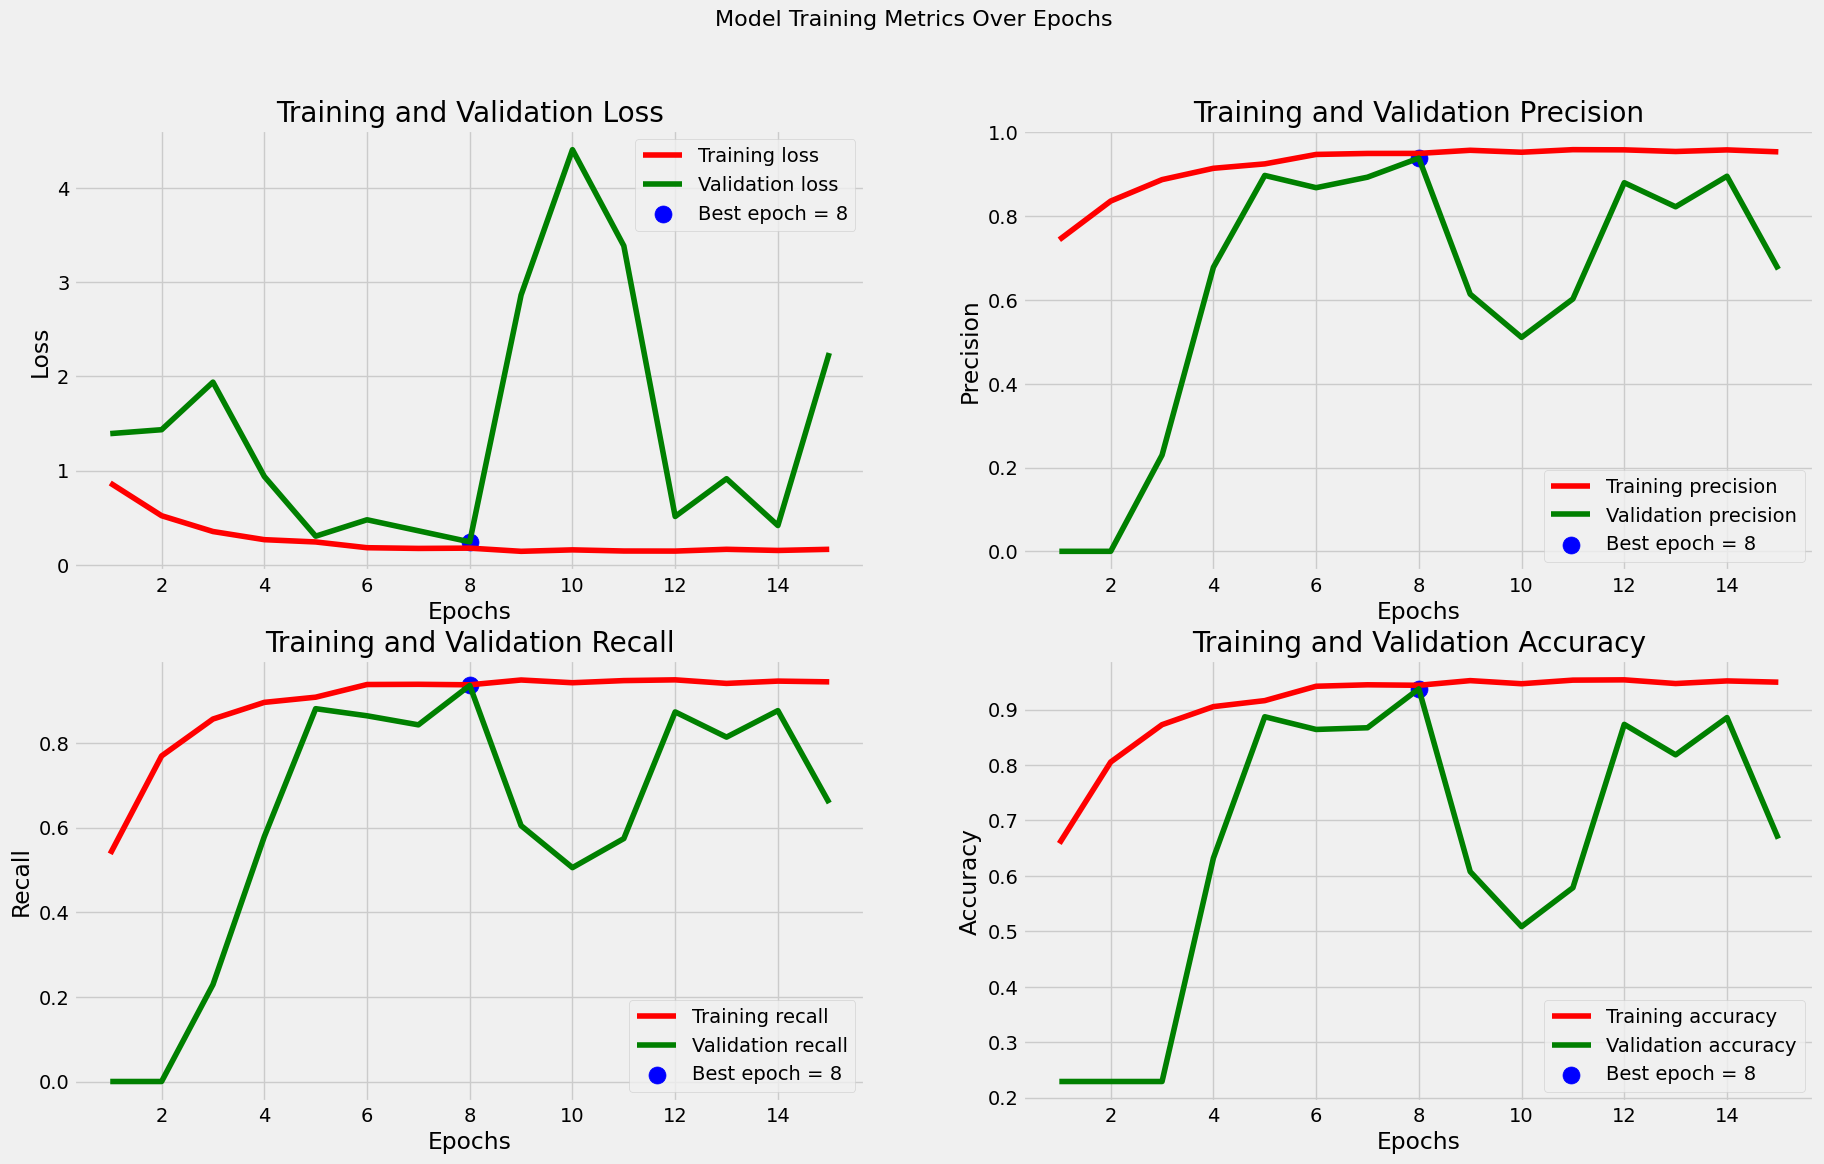

In [ ]:
display_best_model_history(hist)

In [ ]:
evaluation_report(model, train_img_gen, valid_img_gen, test_img_gen)

179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 141ms/step - accuracy: 0.7226 - loss: 1.4803 - precision: 0.7308 - recall: 0.7074
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.6522 - loss: 2.4854 - precision: 0.6587 - recall: 0.6412
 5/41 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7646 - loss: 0.9885 - precision: 0.7937 - recall: 0.7646

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7112 - loss: 1.7597 - precision: 0.7345 - recall: 0.7104
Train Accuracy: 72.46%
Train Loss: 140.9721%
Validation Accuracy: 65.19%
Validation Loss: 247.9002%
Test Accuracy: 71.04%
Test Loss: 177.1763%


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step


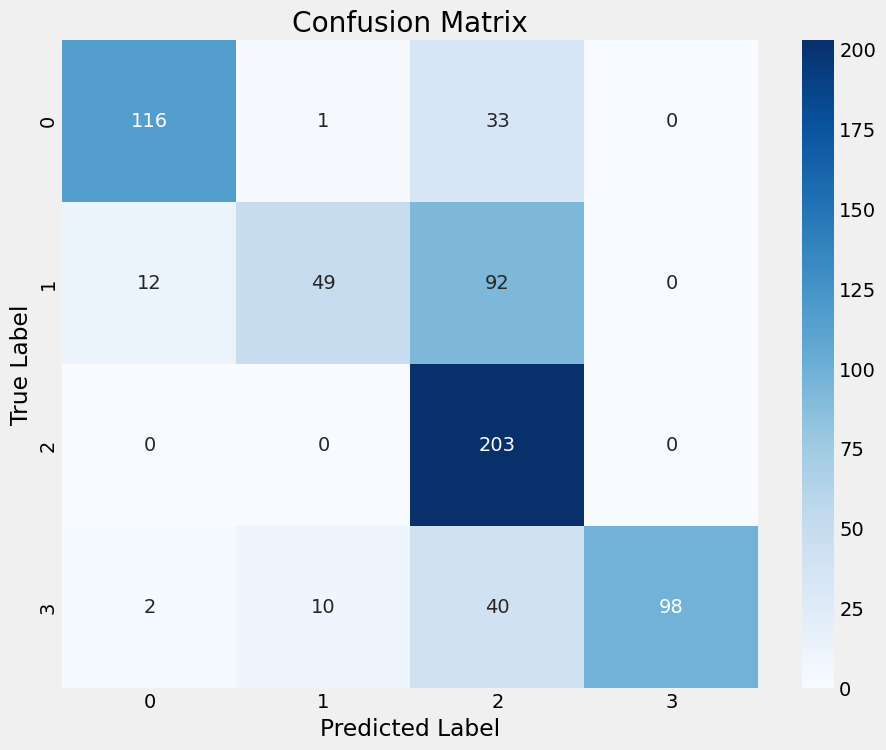

In [ ]:
display_confusion_matrix(model, test_img_gen)

In [ ]:
predict()

# Start of experimentation
## A. In this batch, we are adding checkpoints to store models that run through each epoch, and also finding the best learning rate to use.

In [ ]:
##################################################################################
#
# Run this code if the model was not stored in a file.
# Otherwise, go to the next line to load the saved model from a file
#
##################################################################################

# # Set the initial rate and epochs here
# LEARNING_RATE = 1e-3
# EPOCHS = 25

# model = clone_model(x_model)

# loss_funcs = ['categorical_crossentropy']
# optimizer = tf.keras.optimizers.Adamax(learning_rate=LEARNING_RATE)

# # Callback function to update the learning rate every epoch
# lr_callback = LearningRateScheduler(lambda epoch: LEARNING_RATE * 10**(epoch / 20))

# # Define checkpoint path with epoch formatting
# checkpoint_path = f"/content/exception-1a-{{epoch:02}}.model.keras"

# # Create a ModelCheckpoint callback to save the model's weights
# cp_callback = ModelCheckpoint(
#     filepath=checkpoint_path,
#     monitor='loss',
#     mode='min',
#     save_best_only=True,
# )

# # Compile the model
# model.compile(
#     optimizer=optimizer,
#     loss='categorical_crossentropy',
#     metrics= ['accuracy',
#               Precision(),
#               Recall()
#               ]
# )

# hist = model.fit(
#     train_img_gen,
#     validation_data=valid_img_gen,
#     callbacks=[cp_callback, lr_callback],
#     verbose=1,
#     epochs=EPOCHS,
# )

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 255ms/step - accuracy: 0.5480 - loss: 1.1804 - precision_1: 0.6291 - recall_1: 0.4126 - val_accuracy: 0.2290 - val_loss: 1.3942 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 28s 152ms/step - accuracy: 0.7881 - loss: 0.5302 - precision_1: 0.8219 - recall_1: 0.7507 - val_accuracy: 0.2290 - val_loss: 1.4109 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0011
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 28s 150ms/step - accuracy: 0.8534 - loss: 0.4126 - precision_1: 0.8672 - recall_1: 0.8231 - val_accuracy: 0.2305 - val_loss: 1.4447 - val_precision_1: 0.3837 - val_recall_1: 0.1939 - learning_rate: 0.0013
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 28s 151ms/step - accuracy: 0.8997 - loss: 0.2734 - precision_1: 0.9094 - recall_1: 0.8931 - val_accuracy: 0.7603 - val_loss: 0.6956 - val_precision_1: 0.7944 - val_recall_1: 0.7374 - learning_rate: 0.0014
Epoc

In [ ]:
import json

filename = 'xception_lr-2.8e-3_epoch-10_acc-0.9520'

# Save the entire model
model.save("'{filename} + '.keras'")

filename = f("history_{filename}.json")
# Save the history to a JSON file
with open(filename, 'w') as f:
    json.dump(hist.history, f)

Epoch 10/10
- accuracy: 0.9520
- loss: 0.1454
- precision_1: 0.9559
- recall_1: 0.9451
- val_accuracy: 0.4885
- val_loss: 3.0940
- val_precision_1: 0.4884
- val_recall_1: 0.4840
- learning_rate: 0.0028

In [ ]:
model = load_model('/content/xception_lr-1e-3_epoch-5_acc-0.9351.keras')

ValueError: File not found: filepath=/content/xception_lr-1e-3_epoch-5_acc-0.9351.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
filename = 'history_' + 'xception_lr-1e-3_epoch-5_acc-0.9351'+'.json'
with open(filename, 'r') as f:
    history_data = json.load(f)
history_data

{'accuracy': [0.6486344337463379,
  0.8016456365585327,
  0.8664215803146362,
  0.9072129130363464,
  0.9208683371543884,
  0.9292716979980469,
  0.9346988797187805,
  0.9537814855575562,
  0.9404761791229248,
  0.9520308375358582],
 'loss': [0.8846731185913086,
  0.5142213106155396,
  0.36944612860679626,
  0.266259104013443,
  0.22591421008110046,
  0.20629549026489258,
  0.19296027719974518,
  0.1412203311920166,
  0.18293048441410065,
  0.14538347721099854],
 'precision_1': [0.7274227738380432,
  0.8276511430740356,
  0.8796060085296631,
  0.9163097739219666,
  0.9296679496765137,
  0.9377002716064453,
  0.9424652457237244,
  0.9582670331001282,
  0.9475648999214172,
  0.9576766490936279],
 'recall_1': [0.5400910377502441,
  0.7692577242851257,
  0.8441876769065857,
  0.8989846110343933,
  0.9117646813392639,
  0.9222689270973206,
  0.9262955188751221,
  0.9487044811248779,
  0.9332982897758484,
  0.9467787146568298],
 'val_accuracy': [0.22900763154029846,
  0.22900763154029846,
  

## B. In this line, we change the learning rate to 1e-5

In [ ]:
##################################################################################
#
# Run this code if the model was not stored in a file.
# Otherwise, go to the next line to load the saved model from a file
#
##################################################################################

# # Set the initial rate and epochs here
# LEARNING_RATE = 1e-5
# EPOCHS = 35

# model = clone_model(x_model)

# loss_funcs = ['categorical_crossentropy']
# optimizer = tf.keras.optimizers.Adamax(learning_rate=LEARNING_RATE)

# # Callback function to update the learning rate every epoch
# lr_callback = LearningRateScheduler(lambda epoch: LEARNING_RATE * 10**(epoch / 20))

# # Define checkpoint path with epoch formatting
# checkpoint_path = f"/content/xception-1b_{{epoch:02d}}.model.keras"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# os.makedirs(checkpoint_dir, exist_ok=True)

# # Create a ModelCheckpoint callback to save the model's weights
# cp_callback = ModelCheckpoint(
#     filepath=checkpoint_path,
#     monitor='loss',
#     mode='min',
#     save_best_only=True,
# )

# # Compile the model
# model.compile(
#     optimizer=optimizer,
#     loss='categorical_crossentropy',
#     metrics= ['accuracy',
#               Precision(),
#               Recall()
#               ]
# )

# hist = model.fit(
#     train_img_gen,
#     validation_data=valid_img_gen,
#     callbacks=[cp_callback, lr_callback],
#     verbose=1,
#     epochs=EPOCHS,
# )

Epoch 1/35
179/179 ━━━━━━━━━━━━━━━━━━━━ 83s 258ms/step - accuracy: 0.3252 - loss: 1.6153 - precision_4: 0.3688 - recall_4: 0.2067 - val_accuracy: 0.2290 - val_loss: 1.3894 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 2/35
179/179 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.4523 - loss: 1.2539 - precision_4: 0.5384 - recall_4: 0.3063 - val_accuracy: 0.2290 - val_loss: 1.4041 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - learning_rate: 1.1220e-05
Epoch 3/35
179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 156ms/step - accuracy: 0.5210 - loss: 1.1400 - precision_4: 0.6080 - recall_4: 0.3564 - val_accuracy: 0.2519 - val_loss: 1.4597 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - learning_rate: 1.2589e-05
Epoch 4/35
179/179 ━━━━━━━━━━━━━━━━━━━━ 28s 153ms/step - accuracy: 0.5666 - loss: 1.0274 - precision_4: 0.6742 - recall_4: 0.4144 - val_accuracy: 0.5130 - val_loss: 1.2302 - val_precision_4: 0.7333 - val_recall_4: 0.0672 - learni

Epoch 19/20
- accuracy: 0.9956
- loss: 0.0115
- precision_2: 0.9956
- recall_2: 0.9954
- val_accuracy: 0.9679
- val_loss: 0.1009
- val_precision_2: 0.9679
- val_recall_2: 0.9679
- learning_rate: 7.9433e-05

31/35
- accuracy: 0.9811
- loss: 0.0585
- precision_4: 0.9822
- recall_4: 0.9800
- val_accuracy: 0.9191
- val_loss: 0.3544
- val_precision_4: 0.9205
- val_recall_4: 0.9191
- learning_rate: 3.1623e-04

In [ ]:
# filename = 'xception_lr-3.1623e-04_epoch-35_acc-0.9811'

# # Save the entire model
# model.save(f"{filename}.keras")

# filename = f"history_{filename}.json"
# # Save the history to a JSON file
# with open(filename, 'w') as f:
#     json.dump(hist.history, f)

NameError: name 'model' is not defined

In [ ]:
display_best_model_history(history)

KeyError: 'loss'

# Evaluation

In [ ]:
evaluation_report(model, train_img_gen, valid_img_gen, test_img_gen)

179/179 ━━━━━━━━━━━━━━━━━━━━ 48s 243ms/step - accuracy: 1.0000 - categorical_crossentropy: 2.1798e-04 - loss: 2.1798e-04 - precision_4: 1.0000 - recall_4: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 297ms/step - accuracy: 0.9887 - categorical_crossentropy: 0.0494 - loss: 0.0494 - precision_4: 0.9887 - recall_4: 0.9887
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9809 - categorical_crossentropy: 0.0800 - loss: 0.0800 - precision_4: 0.9809 - recall_4: 0.9809
Train Accuracy: 0.03%
Train Loss: 0.0326%
Validation Accuracy: 3.85%
Validation Loss: 3.8455%
Test Accuracy: 8.61%
Test Loss: 8.6125%


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step


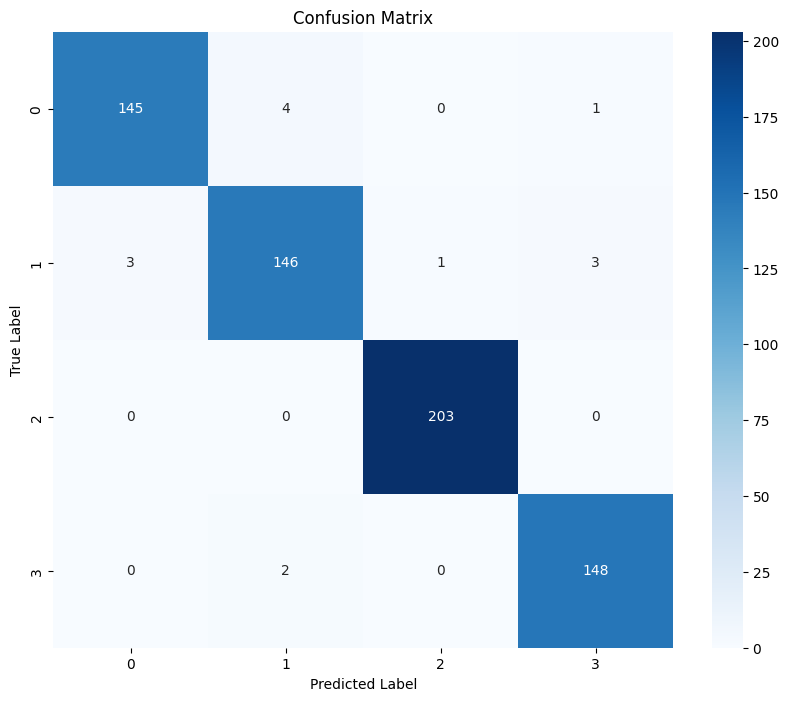

In [ ]:
display_confusion_matrix(model, test_img_gen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Predicted tumor type: meningioma


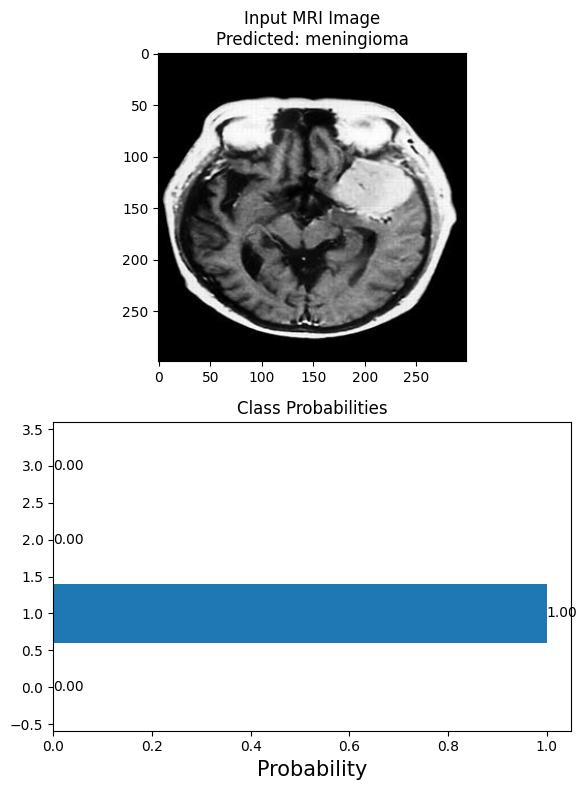

In [ ]:
predict('/content/Testing/meningioma/Te-meTr_0005.jpg')

# Model Architecture: CNN (Convolutional Neural Networks)

img 8: Xception model vs custom CNN model

img 9: Deploying models

### What is a Convolutional Neural Network?
to do later

### Activation Functions
* **ReLU**: applies non-linearity into model which is important in learning more and producint more accuracy int heir predictions. The ReLU activation function is specifically used as a non-linear activation function, as opposed to other non-linear functions such as Sigmoid because it has been empirically observed that CNNs using ReLU are faster to train than their counterparts.

img 11

* **Softmax**: makes sure that CNN outputs sum to 1. This is useful to scale model outputs into probabilities. Remember that backpropagation is a key aspect of training neural networks—we want the correct answer to have the largest “signal.” By using softmax, we are effectively “approximating” argmax while gaining differentiability. Rescaling doesn’t weigh the max significantly higher than other logits, whereas softmax does. Simply put, softmax is a “softer” argmax.

* **Pooling Layers**: is used for gradually decreasing the spatial extent of the network, which reduces the parameters and overall computation of the network. **Max Pooling** is basically a smart summarizer for our image data. It focuses on the most important features in the images. It works by looking at small sections of the image, one at a time, keeping only the most standout pixel with the highest value from each section of the image. And this process helps our model by reducing the amount of information to process, making it faster and more efficient, while retaining the most crucial details.

* **Flatten Layer**: This layer converts a three-dimensional layer in the network into a one-dimensional vector to fit the input of a fully-connected layer for classification

img12

### Regularizers
* **L1 (Ridge Regression)**: encourages feature selection by eliminating unimportant features. It penalizes the sum of absolute values of the weights. L1 can deal with sparse feature spaces.
* **L2 (Lasso Regression)**: is effective for handling multicollinearity and prioritizing model accuracy and stabiltiy. It allows for smaller but non-zero coefficients. It penalizes the sum of squares of the weights.

### Loss Functions
* **Mean squared error**
* **Mean absolute error**
* **Huber loss**
* **Cross entropy (log loss or negative log-likelihood loss)**
* **Hinge Loss**

In [ ]:
BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)

image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))
train_img_gen = image_generator.flow_from_dataframe(
    train_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE
  )
valid_img_gen = image_generator.flow_from_dataframe(
    valid_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE
  )

test_image_generator = ImageDataGenerator(rescale=1/255)
test_img_gen = test_image_generator.flow_from_dataframe(
    test_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=16,
    target_size=IMAGE_SIZE,
    shuffle=False
  )

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## Model Architecture 1

As the base model, we will be using 4 blocks with (512, 256, 128, ...) parameters

In [ ]:
# Create the cnn with 4 blocks
cnn_model = Sequential([
  # Block 1
  Conv2D(512, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),

  # Block 2
  Conv2D(256, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),

  # Block 3
  Conv2D(128, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),

  # Block 4
  Conv2D(64, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),

  # Flatten the output for fully connected layers
  Flatten(),

  # Fully connected layers
  Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
  Dropout(rate=0.25),
  # Output 4 neurons for 4 classes
  Dense(4, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
##################################################################################
#
# Run this code if the model was not stored in a file.
# Otherwise, go to the next line to load the saved model from a file
#
##################################################################################


# Set the initial rate and epochs here
LEARNING_RATE = 1.9953e-04
EPOCHS = 30

model = clone_model(cnn_model)

loss_funcs = ['categorical_crossentropy']
optimizer = tf.keras.optimizers.Adamax(learning_rate=LEARNING_RATE)

# Callback function to update the learning rate every epoch
lr_callback = LearningRateScheduler(lambda epoch: LEARNING_RATE * 10**(epoch / 20))

# Define checkpoint path with epoch formatting
checkpoint_path = f"/content/cnn1-{{epoch:02d}}.model.keras"

# Create a ModelCheckpoint callback to save the model's weights
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='loss',
    mode='min',
    save_best_only=True,
)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics= ['accuracy',
              Precision(),
              Recall()
              ]
)

hist = model.fit(
    train_img_gen,
    validation_data=valid_img_gen,
    callbacks=[cp_callback, lr_callback],
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.5260 - loss: 3.9337 - precision_3: 0.6923 - recall_3: 0.3056 - val_accuracy: 0.7282 - val_loss: 2.2549 - val_precision_3: 0.7878 - val_recall_3: 0.6122 - learning_rate: 1.9953e-04
Epoch 2/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.7695 - loss: 2.0144 - precision_3: 0.7977 - recall_3: 0.7123 - val_accuracy: 0.7435 - val_loss: 1.7288 - val_precision_3: 0.7951 - val_recall_3: 0.6870 - learning_rate: 2.2388e-04
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.8332 - loss: 1.4943 - precision_3: 0.8528 - recall_3: 0.8027 - val_accuracy: 0.7893 - val_loss: 1.3662 - val_precision_3: 0.8151 - val_recall_3: 0.7603 - learning_rate: 2.5119e-04
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.8551 - loss: 1.1762 - precision_3: 0.8645 - recall_3: 0.8375 - val_accuracy: 0.8611 - val_loss: 1.0333 - val_precision_3: 0.8794 - val_recall_3: 0.8458 - learning_rate: 2.8184e-04
Epoch 5/

In [ ]:
save_model_and_history(model, hist.history, 'cnn1_')

Model is saved in /content/cnn1_.keras, history is saved in /content/history_cnn1_.json


In [ ]:
model, history = load_model_and_history_from_file('cnn1_')

In [ ]:
display_history(history)

NameError: name 'display_history' is not defined

In [ ]:
evaluation_report(model, train_img_gen, valid_img_gen, test_img_gen)

357/357 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9835 - loss: 0.3709 - precision_3: 0.9855 - recall_3: 0.9834
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.9544 - loss: 0.4597 - precision_3: 0.9569 - recall_3: 0.9512
 7/41 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8981 - loss: 0.5863 - precision_3: 0.8981 - recall_3: 0.8981

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9270 - loss: 0.5126 - precision_3: 0.9272 - recall_3: 0.9270
Train Accuracy: 98.13%
Train Loss: 37.0913%
Validation Accuracy: 95.27%
Validation Loss: 48.4385%
Test Accuracy: 93.75%
Test Loss: 50.7595%


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step


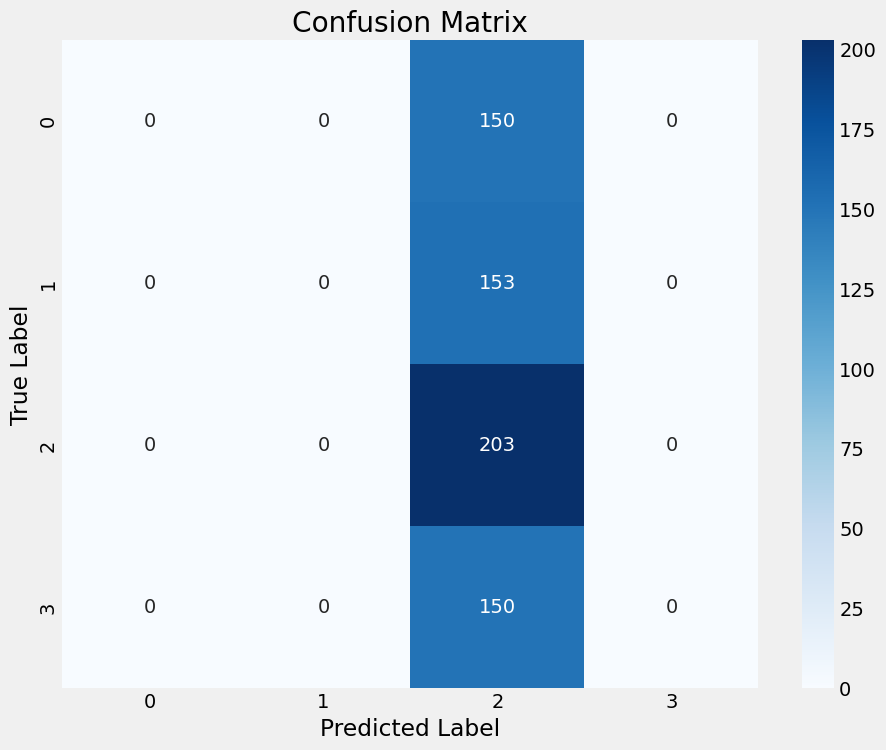

In [ ]:
display_confusion_matrix(cnn_model, test_img_gen)

In [ ]:
predict('/content/Testing/meningioma/Te-meTr_0005.jpg')
model.save_weights('cnn_model.weights.h5')

NameError: name 'predict' is not defined

## Model Architecture 2

In [ ]:
cnn2_model = Sequential([
    # Entry Flow
    Conv2D(32, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(512, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Flatten the output for fully connected layers
    Flatten(),

    # Adjusted Dense layer to match flattened output size (4096)
    Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.25),

    # Output layer for 4 classes
    Dense(4, activation='softmax')
])

In [ ]:
##################################################################################
#
# Run this code if the model was not stored in a file.
# Otherwise, go to the next line to load the saved model from a file
#
##################################################################################

# Set the initial rate and epochs here
LEARNING_RATE = 1.9953e-04
EPOCHS = 30

model = clone_model(cnn2_model)

loss_funcs = ['categorical_crossentropy']
optimizer = tf.keras.optimizers.Adamax(learning_rate=LEARNING_RATE)

# Callback function to update the learning rate every epoch
lr_callback = LearningRateScheduler(lambda epoch: LEARNING_RATE * 10**(epoch / 20))

# Define checkpoint path with epoch formatting
checkpoint_path = f"/content/cnn2-{{epoch:02d}}.model.keras"

# Create a ModelCheckpoint callback to save the model's weights
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='loss',
    mode='min',
    save_best_only=True,
)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics= ['accuracy',
              Precision(),
              Recall()
              ]
)

hist = model.fit(
    train_img_gen,
    validation_data=valid_img_gen,
    callbacks=[cp_callback, lr_callback],
    verbose=1,
    epochs=EPOCHS,
)



Epoch 1/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.4395 - loss: 24.6919 - precision_5: 0.6057 - recall_5: 0.2246 - val_accuracy: 0.6015 - val_loss: 2.2130 - val_precision_5: 0.6994 - val_recall_5: 0.3802 - learning_rate: 1.9953e-04
Epoch 2/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - accuracy: 0.7367 - loss: 1.5175 - precision_5: 0.7798 - recall_5: 0.6549 - val_accuracy: 0.7023 - val_loss: 1.0186 - val_precision_5: 0.7404 - val_recall_5: 0.6183 - learning_rate: 2.2388e-04
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - accuracy: 0.7912 - loss: 0.7952 - precision_5: 0.8189 - recall_5: 0.7590 - val_accuracy: 0.7282 - val_loss: 0.7888 - val_precision_5: 0.7698 - val_recall_5: 0.6534 - learning_rate: 2.5119e-04
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.8303 - loss: 0.6514 - precision_5: 0.8506 - recall_5: 0.7937 - val_accuracy: 0.8214 - val_loss: 0.6381 - val_precision_5: 0.8510 - val_recall_5: 0.7847 - learning_rate: 2.8184e-04
Epoch 5

In [ ]:
learning_rate = 2.238721208414063e-05

In [ ]:
save_model_and_history(model, hist.history, 'cnn2_')

Model is saved in /content/cnn2_.keras, history is saved in /content/history_cnn2_.json


In [ ]:
load_model_and_history_from_file('cnn2_')

## Model Architecture 3

In [ ]:
cnn3_model = Sequential([
    # Entry Flow
    Conv2D(32, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(512, (3, 3), padding='same', activation='relu'),
    # Optionally, remove pooling to avoid shrinking dimensions too much
    Dropout(0.25),

    Conv2D(728, (3, 3), padding='same', activation='relu'),
    # Smaller pooling size or remove this pooling layer if needed
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Exit flow
    Conv2D(1024, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(2048, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Flatten the output for fully connected layers
    Flatten(),

    # Fully connected layer
    Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.25),

    # Output layer for 4 classes
    Dense(4, activation='softmax')
])

In [ ]:
##################################################################################
#
# Run this code if the model was not stored in a file.
# Otherwise, go to the next line to load the saved model from a file
#
##################################################################################

# Set the initial rate and epochs here
LEARNING_RATE = 2.238721208414063e-05
EPOCHS = 25

model = clone_model(cnn3_model)

loss_funcs = ['categorical_crossentropy']
optimizer = tf.keras.optimizers.Adamax(learning_rate=LEARNING_RATE)

# Callback function to update the learning rate every epoch
lr_callback = LearningRateScheduler(lambda epoch: LEARNING_RATE * 10**(epoch / 20))

# Define checkpoint path with epoch formatting
checkpoint_path = f"/content/cnn3-{{epoch:02d}}.model.keras"

# Create a ModelCheckpoint callback to save the model's weights
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='loss',
    mode='min',
    save_best_only=True,
)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics= ['accuracy',
              Precision(),
              Recall()
              ]
)

hist = model.fit(
    train_img_gen,
    validation_data=valid_img_gen,
    callbacks=[cp_callback, lr_callback],
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - accuracy: 0.3110 - categorical_crossentropy: 1.3247 - loss: 24.5289 - precision_8: 0.8308 - recall_8: 0.0356
Epoch 2/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.5915 - categorical_crossentropy: 0.9302 - loss: 13.2309 - precision_8: 0.7046 - recall_8: 0.3818
Epoch 3/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.6832 - categorical_crossentropy: 0.7460 - loss: 7.8339 - precision_8: 0.7448 - recall_8: 0.5918
Epoch 4/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7470 - categorical_crossentropy: 0.6516 - loss: 4.9581 - precision_8: 0.7793 - recall_8: 0.6830
Epoch 5/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.7770 - categorical_crossentropy: 0.5424 - loss: 3.3206 - precision_8: 0.8028 - recall_8: 0.7463
Epoch 6/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8051 - categorical_crossentropy: 0.4911 - loss: 2.3992 - precision_8: 0.8235 - recall_8: 0.7740
Epoch 7/25
357

In [ ]:
save_model_and_history(cnn3_model, history.history, 'cnn3_')

Model is saved in /content/cnn3_.keras, history is saved in /content/history_cnn3_.json


In [ ]:
load_model_and_history_from_file('cnn3_')

# Part 2: Streamlit Web App

* **pyngrok**: allows us to get a link from our local dev.
* **Thread**:
* **Replace2Linear()**: When the softmax activation function is applied to the last layer of model, it may obstruct generating the attention images, so you should replace the function to a linear activation function. Although we create and use ReplaceToLinear instance here, we can also use the model modifier function defined by ourselves

In [1]:
!pip install streamlit pyngrok python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.8 MB/s eta 0:00:00


In [2]:
from threading import Thread
from pyngrok import ngrok
import os
from google.colab import userdata
from google.colab import userdata
from dotenv import load_dotenv

In [3]:
# Set api keys in .env

%%writefile .env
NGROK_AUTH_TOKEN=
GOOGLE_API_KEY=

Writing .env


In [4]:
# Set the token manually via os.environ
# os.environ['NGROK_AUTH_TOKEN'] =
# ngrok_token = os.environ['NGROK_AUTH_TOKEN']

load = load_dotenv()
ngrok.set_auth_token(os.getenv('NGROK_AUTH_TOKEN'))

In [81]:
# This code write the app.py in our working directory
%%writefile utils.py

import streamlit as st
import tensorflow as tf
import numpy as np
import plotly.graph_objects as go
import cv2
import json
import google.generativeai as genai
import PIL.Image
import os
import matplotlib.pyplot as plt
import gdown

from pprint import pprint
from scipy.ndimage import zoom
from google.colab import userdata
from dotenv import load_dotenv

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input
# from tensorflow.keras.applications.vgg16 import preprocess_input
# from tensorflow.keras.layers import Dense, Dropout, Flatten
# from tensorflow.keras.optimizers import Adamax
# from tensorflow.keras.metrics import Precision, Recall

load = load_dotenv()
genai.configure(api_key=os.getenv('GOOGLE_API_KEY'))


# def load_xception_model(model_path):
#   img_shape=(299, 299, 3)
#   base_model = tf.keras.application.Xception(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

#   model = Sequential([
#       base_model,
#       Flatten(),
#       Dropout(rate=0.3),
#       Dense(128, activation='relu'),
#       Dropout(rate=0.25),
#       Dense(4, activation='softmax')
#   ])

#   model.build((None, ) + img_shape)

#   # Compile the model
#   model.compile(Adamax(learning_rate=0.001),
#     loss='categorical_crossentropy',
#     metrics=['accuracy', Precision(), Recall()
#   ])

#   model.load_weights(model_path)

#   return model

class Model:
  def __init__(self, model, img_size):
    self.model = model,
    self.img_size = img_size


labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

@st.cache_resource
def load_models():
    models = {}

    # Load xception model
    file = 'https://drive.google.com/file/d/1kOsrVm-nfTksSwK6AoCfgb4NNIlPQ4-O/view?usp=sharing'
    url = f'https://drive.google.com/uc?id={file.split("/")[-2]}'
    output = 'xception_1_.keras'
    gdown.download(url, output, quiet=False)
    model = load_model(output)
    img_size = (299, 299)
    models['xception'] = Model(model, img_size)

    # Load cnn model
    file = 'https://drive.google.com/file/d/1b0KD81MByk2Q4gQ9ktjx-BORKVt94G1M/view?usp=sharing'
    url = f'https://drive.google.com/uc?id={file.split("/")[-2]}'
    output = 'cnn1_.keras'
    gdown.download(url, output, quiet=False)
    model = load_model(output)
    img_size = (224, 224)
    models['sequential'] = Model(model, img_size)

    return models

def create_model_probability_chart(probabilities, model):
    models = list(probabilities.keys())
    probs = list(probabilities.values())

    fig = go.Figure(data=[
        go.Bar(
            y=models,
            x=probs,
            orientation="h",
            text=[f"{p: .4%}" for p in probs],
            textposition="auto"
        )
    ])
    fig.update_layout(
        title= f"Brain Tumor Classification Probability by the {model}",
        yaxis_title="Tumor types",
        xaxis_title="Probability",
        xaxis=dict(tickformat=".0%", range=[0, 1]),
        height=400,
        margin=dict(l=20, r=20, t=40, b=20)
    )

    return fig

def convert_img_to_array(img):
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0
  return img_array

def generate_saliency_map(model, img, uploaded_file, class_index, img_size):
  # Convert image to numpy array and batch
  img_array = convert_img_to_array(img)

  # Create the saliency_maps directory if it doesn't exist
  output_dir = 'saliency_maps'
  os.makedirs(output_dir, exist_ok=True)

  # Convert image to tensor
  with tf.GradientTape() as tape:
    img_tensor = tf.convert_to_tensor(img_array)
    tape.watch(img_tensor)
    predictions = model(img_tensor)
    target_class = predictions[:, class_index]

  gradients = tape.gradient(target_class, img_tensor)
  gradients = tf.math.abs(gradients)
  gradients = tf.reduce_max(gradients, axis=-1)
  gradients = gradients.numpy().squeeze()
  # st.write(f'saliency graidents {gradients.shape}')

  # Resize gradients to match original image size
  gradients = cv2.resize(gradients, img_size)
  # st.write(f'saliency graidents resize {gradients.shape}')

  # Create a circular mask for the brain area
  center = (gradients.shape[0] // 2, gradients.shape[1] // 2)
  radius = min(center[0], center[1]) - 10
  y, x = np.ogrid[:gradients.shape[0], :gradients.shape[1]]
  mask = ((x - center[0])**2 + (y - center[1])**2) <= radius**2

  # Apply mask to gradients
  gradients = gradients * mask

  # Normalize only the brain area
  brain_gradients = gradients[mask]
  if brain_gradients.max() > brain_gradients.min():
    brain_gradients = (brain_gradients - brain_gradients.min()) / (brain_gradients.max() - brain_gradients.min())
  gradients[mask] = brain_gradients

  # Apply a higher threshold
  threshold = np.percentile(gradients[mask], 80)
  gradients[gradients < threshold] = 0

  # Apply more aggressive smoothing
  gradients = cv2.GaussianBlur(gradients, (11, 11), 0)
  # st.write(f'saliency graidents {gradients.shape}')

  # Create a heatmap overlay with enhanced contrast
  heatmap = cv2.applyColorMap(np.uint8(255 * gradients), cv2.COLORMAP_JET)
  heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
  # st.write(f'saliency headmap: {heatmap.shape}')

  # Resize heatmap to match original image size
  heatmap = cv2.resize(heatmap, img_size)
  st.write(f'saliency heatmap resize:  {gradients.shape}')

  # Superimpose the heatmap on original image with increased opacity
  original_img = image.img_to_array(img)
  superimposed_img = heatmap * 0.90 + original_img * 0.35
  superimposed_img = superimposed_img.astype(np.uint8)
  # st.write(f'saliency superimposed: {superimposed_img.shape}')

  img_path = os.path.join(output_dir, uploaded_file.name)
  with open(img_path, 'wb') as f:
    f.write(uploaded_file.getbuffer())

  saliency_map_path = f'{output_dir}/{uploaded_file.name}'

  # Save the saliency map
  cv2.imwrite(saliency_map_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))

  return superimposed_img


def generate_explanation(uploaded_file, img_path, model_prediction, confidence):
  orig = PIL.Image.open(uploaded_file)
  img = PIL.Image.open(img_path)
  model = genai.GenerativeModel(model_name='gemini-1.5-flash')

  prompt1 = f"""
    You are a leading neurologist and specialist in brain tumor diagnosis.
    You are provided with two images:
    * {orig} : This image is an MRI scan of the brain.
    * {img}: This image highlights the area of where the model is looking at.

    Your task is to interpret a saliency map from an MRI scan. This map, created by a deep learning model,
    has highlighted specific brain regions it focused on to classify the tumor.
    The model was trained to identify four categories: glioma, meningioma, pituitary tumor, or no tumor.

    The model has classified the image as '{model_prediction}' with a confidence level of {confidence * 100:.2f}%.

    In your explanation:
    - Describe the regions of the brain that the model focused on, particularly those highlighted in light cyan on the saliency map.
    - Offer insights on why these specific areas contributed to the model's classification.
    - Avoid directly stating 'the model is focusing on areas in light cyan'—instead, convey this more naturally in your explanation.
    - Limit your explanation to 4 sentences for concise clarity.
    - Think through your explanation step-by-step, ensuring accuracy in each detail.
  """

  response = model.generate_content([
    prompt1,
    orig,
    img,
    ])
  return response.text


def generate_modes(explanation):
  model = genai.GenerativeModel(model_name='gemini-1.5-flash')
  prompt2 = f"""
    As a skilled communication expert, your task is to explain this {explanation} to various audiences.

    Please generate four distinct explanations for the following groups:
    - 'genz': Use language that resonates with Gen Z, keeping it informal and minimizing medical jargon.
    - '5th-grader': Use simple, accessible language suited for a 5th-grader, avoiding any technical terms.
    - 'normal': Cater to an adult audience with clear, everyday language that balances simplicity with thoroughness.
    - 'expert': Tailor your explanation for medical professionals, integrating technical details relevant to tumor diagnosis.

    In your response for each group:
    - Do not explicitly mention phrases like 'the model is focusing on areas in light cyan'—instead, phrase this naturally within your explanation.
    - Keep each explanation brief (no more than 10 sentences).
    - Avoid using the words 'computer' or 'AI'.

    Please format your response as JSON, using this schema:
    {{
        "genz": str,
        "5th-grader": str,
        "normal": str,
        "expert": str
    }}
    Return: list[Mode]
  """

  response = model.generate_content([
      prompt2,
      explanation,
      ])
  return response.text

def generate_cross_diagnosis(uploaded_file, img_path, model_prediction, confidence, explanation):
    orig = PIL.Image.open(uploaded_file)
    img = PIL.Image.open(img_path)
    model = genai.GenerativeModel(model_name='gemini-1.5-flash')
    prompt = f"""
    The model predicted the image {model_prediction} with {confidence *100}% confidence. Here's the model's explanation: {explanation}
    As an LLM analyzing MRI scans, your task is to evaluate two images of brain MRI scans.
    On a magnetic resonance imaging (MRI) scan, brain tumors typically appear as abnormal masses or growths.
    Healthcare providers look for the following characteristics when evaluating MRI scans for brain tumors:
    * Size, shape, and location: The tumor's size, shape, and location are noted.
    * Contrast enhancement: Contrast-enhanced MRI scans are especially useful
    because they can help distinguish tumor tissue from surrounding healthy tissue.
    * T1-weighted images: Most brain tumors are hypointense on T1-weighted images.
    * T2-weighted images: Most brain tumors are hyperintense on T2-weighted images.
    * FLAIR sequences: Most brain tumors are hyperintense on FLAIR sequences.
    * Diffusion-weighted imaging (DWI): Absence of restricted water movement is a typical finding.
    * Metabolites: Certain metabolites, such as lipids, myo-inositol, and 2-hydroxyglutarate, can indicate the presence of a brain tumor.

    Other characteristics of brain tumors on MRI scans include:
    * A large cystic lesion with a mural nodule
    * A mass that has spread in the middle area of the brain
    * Degrees of brightness with contrast

    Based on these characteristics you will follow a detailed step-by-step process to identify areas that may correspond to tumor formations.
    For each image, perform the following steps to reach a comprehensive assessment of the model’s predictions:

    1. Identify the Predicted Area:
      a. Begin by locating the specific region in the MRI scan where the model has identified
      a potential abnormality or tumor. This may be in areas associated with common brain tumors, such as:
          - Pituitary (often a small, pea-sized structure at the base of the brain)
          - Glioma Region (usually in the cerebral hemispheres, involving glial cells in the brain)
          - Meningioma Region (typically located in the meninges, the protective layers surrounding the brain and spinal cord)
      b. Mark the exact coordinates or spatial area as identified by the model, if possible, using any available labeling or overlay for the model’s predicted location.

    2. Analyze the Area’s Characteristics:
      a. Describe the specific features of the identified area in the scan, including:
          - Size, shape, and contrast (lighter or darker areas that may indicate density differences).
          - Presence of any irregularities in the tissue, such as:
          - Tumor-like formations (e.g., unusual mass, irregular borders).
          - Enlargement or swelling (increased volume around the area).
          - Changes in structure, such as displacement of surrounding tissues.
          - other characteristics mentioned above.
      b. Note any observable signs of common brain tumors. For instance:
          - Pituitary tumors often cause enlargement of the pituitary gland.
          - Gliomas may show irregular, diffuse areas, especially in the frontal or temporal lobes.
          - Meningiomas typically appear as well-circumscribed masses near the skull base.

    3. Identify Abnormalities:
      a. Based on the observations, assess whether there are abnormalities in the area, such as:
          - Presence of masses, unusual densities, or structural distortions.
          - Symmetry and consistency with known anatomical structures.
      b. Indicate if the characteristics align with typical tumor presentations or other possible conditions (e.g., cysts, benign growths, or swelling).

    4. Cross-Image Assessment:
      a. Next, analyze the second MRI image where the model has made another prediction. Apply the same identification and analysis steps:
        - Observe and describe any structures and characteristics in the predicted area.
        - Check for consistency with the first image’s findings, especially if it is a follow-up or alternate view of the same region.

    5. Evaluate the Model’s Prediction:
      a. Based on your analysis of both images, assess if the model’s prediction is likely correct. Consider:
        - Alignment of the model’s prediction with observed physical characteristics (e.g., size, shape, location).
        - Any anatomical or clinical features that may either confirm or contradict the presence of a tumor.
        - Whether similar features appear across both images, supporting the presence of a tumor or other abnormality.
      b. Provide a detailed explanation of why you think the model’s prediction is accurate or inaccurate. If inaccurate, suggest possible reasons (e.g., overlapping structures, artifacts, or limitations in MRI clarity).
    6. Conclude Your Evaluation:
      a.Summarize your final assessment, stating whether you agree or disagree with the model’s initial prediction.
      Specify if the detected area in the MRI scan corresponds to a tumor based on observed abnormalities and anatomical context.
      b. If possible, suggest further imaging or analysis steps that might enhance accuracy,
      such as using higher-resolution images, additional MRI slices, or applying contrast agents to differentiate between tumor and healthy tissue.
    """
    model = genai.GenerativeModel(model_name='gemini-1.5-flash')
    response = model.generate_content([
      prompt,
      orig,
      img
      ])


    return response.text


# Function to load image and predict
def load_and_predict(model, uploaded_file, img_size=(299, 299)):
    img = image.load_img(uploaded_file, target_size=img_size)
    img_array = convert_img_to_array(img)
    prediction = model.predict(img_array)

    # Get the class with the highest probability
    predicted_class_idx = np.argmax(prediction[0])
    result = labels[predicted_class_idx]
    return prediction, result, predicted_class_idx

# Function to generate and display saliency map and results
def display_results(model, uploaded_file, prediction, result, predicted_class_idx, img_size):
    prediction_dict = {label: prob for label, prob in zip(labels, prediction[0])}
    fig = create_model_probability_chart(prediction_dict, model)
    st.plotly_chart(fig)

    saliency_map = generate_saliency_map(model, image.load_img(uploaded_file, target_size=img_size), uploaded_file, predicted_class_idx, img_size)
    saliency_map_path = f'saliency_maps/{uploaded_file.name}'

    col1, col2 = st.columns(2)
    with col1:
        st.image(uploaded_file, caption='Uploaded Image', use_container_width=True)
    with col2:
        st.image(saliency_map, caption='Saliency Map', use_container_width=True)

# Function to display prediction and confidence
def display_prediction_and_confidence(result, confidence):
    col1, col2 = st.columns([1, 1])
    with col1:
        st.markdown(
            f"""
            <div style='display: flex; align-items: center; justify-content: center; height: 100%; width: 100%;'>
                <div style='background-color: #000000; color: #ffffff; padding: 20px; border-radius: 15px; text-align: center; width: 100%;'>
                    <h3 style='color: #ffffff; font-size: 20px;'>Prediction</h3>
                    <p style='font-size: 36px; font-weight: 800; color: #ff0000; margin: 0;'>
                        {result}
                    </p>
                </div>
            </div>
            """,
            unsafe_allow_html=True
        )

    with col2:
        st.markdown(
            f"""
            <div style='display: flex; align-items: center; justify-content: center; height: 100%; width: 100%;'>
                <div style='background-color: #000000; color: #ffffff; padding: 20px; border-radius: 15px; text-align: center; width: 100%;'>
                    <h3 style='color: #ffffff; font-size: 20px;'>Confidence</h3>
                    <p style='font-size: 36px; font-weight: 800; color: #2196F3; margin: 0;'>
                        {confidence:.4%}
                    </p>
                </div>
            </div>
            """,
            unsafe_allow_html=True
        )

# Function to create explanation tabs
def display_explanation_tabs(uploaded_file, saliency_map_path, result, confidence):
    explanation = generate_explanation(uploaded_file, saliency_map_path, result, confidence)
    data = generate_modes(explanation)
    data_string_cleaned = data.replace('```json', '').replace('```', '').strip()
    explanations = json.loads(data_string_cleaned)

    st.write('#### Explanation')
    with st.container(border=True):
        tab1, tab2, tab3, tab4 = st.tabs(['Normal', 'Expert', '5th-grader', 'Gen-Z'])

        with tab1:
            st.write(explanations['normal'])
        with tab2:
            st.write(explanations['expert'])
        with tab3:
            st.write(explanations['5th-grader'])
        with tab4:
            st.write(explanations['genz'])

    st.write('#### Cross-Diagnosis')
    diagnosis = generate_cross_diagnosis(uploaded_file, saliency_map_path, result, confidence, explanation)
    st.write(diagnosis)

Overwriting utils.py


In [82]:
# This code write the app.py in our working directory
%%writefile app.py

import streamlit as st
# import tensorflow as tf
# import numpy as np
# import plotly.graph_objects as go
# import cv2
# import json
# import google.generativeai as genai
# import PIL.Image
# import os
# import matplotlib.pyplot as plt


# from pprint import pprint
# from scipy.ndimage import zoom
# from google.colab import userdata
# from dotenv import load_dotenv

# from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, Input
from utils import (
    load_models,
    create_model_probability_chart,
    generate_saliency_map,
    generate_explanation,
    generate_modes,
    generate_cross_diagnosis,
    convert_img_to_array,
    display_explanation_tabs,
    display_prediction_and_confidence,
    display_results,
    load_and_predict
)


##########################################################################################
#
#     START OF FRONTEND UI
#
##########################################################################################

models = load_models()
modelNames = list(models.keys())

st.title('Brain Tumor Classification')
st.write('Upload an image of a brain MRI scan to classify.')
uploaded_file = st.file_uploader('Choose an image...', type=['jpg', 'jpeg', 'png'])

if uploaded_file is not None:

  # Tabs for each model
  model_tab1, model_tab2 = st.tabs([name.title() for name in modelNames])

  # Model 1 Tab
  with model_tab1:
      st.write(f"## Model 1 Results")
      modelName = modelNames[0]
      model1 = models[modelName].model[0]
      img_size1 = models[modelName].img_size

      prediction, result, predicted_class_idx = load_and_predict(model1, uploaded_file, img_size1)
      display_results(model1, uploaded_file, prediction, result, predicted_class_idx, img_size=img_size1)
      display_prediction_and_confidence(result, prediction[0][predicted_class_idx])
      display_explanation_tabs(uploaded_file, f'saliency_maps/{uploaded_file.name}', result, prediction[0][predicted_class_idx])

  # Model 2 Tab
  with model_tab2:
      st.write("## Model 2 Results")
      modelName = modelNames[1]
      model2 = models[modelName].model[0]
      img_size2 = models[modelName].img_size

      prediction, result, predicted_class_idx = load_and_predict(model2, uploaded_file, img_size2)
      display_results(model2, uploaded_file, prediction, result, predicted_class_idx, img_size=img_size2)
      display_prediction_and_confidence(result, prediction[0][predicted_class_idx])
      display_explanation_tabs(uploaded_file, f'saliency_maps/{uploaded_file.name}', result, prediction[0][predicted_class_idx])

Overwriting app.py


In [56]:
def run_streamlit():
  os.system('streamlit run /content/app.py --server.port 8501')

In [8]:
# Thread allows to run the programs in parallel.
thread = Thread(target=run_streamlit)
thread.start()

In [9]:
public_url = ngrok.connect(addr='8501', proto='http', bind_tls=True)
print('Public URL:', public_url)

Public URL: NgrokTunnel: "https://cf39-34-16-145-80.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
tunnels = ngrok.get_tunnels()

for tunnel in tunnels:
  print(f"Closing tunnel: {tunnel.public_url} -> {tunnel.config['addr']}")
  ngrok.disconnect(tunnel.public_url)

Closing tunnel: https://8188-35-229-179-140.ngrok-free.app -> http://localhost:8501
Closing tunnel: https://2abc-35-229-179-140.ngrok-free.app -> http://localhost:8501


Closing tunnel: https://9103-35-229-179-140.ngrok-free.app -> http://localhost:8501


# TESTING

In [ ]:
import os
import numpy as np
import tensorflow as tf
import keras
import cv2

# Display
from IPython.display import Image, display
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image



def generate_gradcam_map(model, prediction, img_array, img_size=(224, 224)):
    # Create the gradcam directory if it doesn't exist
    output_dir = 'gradcam_maps'
    os.makedirs(output_dir, exist_ok=True)

    H, W = img_size
    cls = np.argmax(prediction)

    # Find the last convolutional layer
    last_conv_layer = None
    for layer in reversed(model.layers):
        if 'conv' in layer.name or 'Conv' in layer.name or isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer = layer
            break
    if last_conv_layer is None:
        raise ValueError("No convolutional layer found in the model.")

    # # Use the existing trained model, no need to redefine or load weights separately
    grad_model = Sequential([
      Input(shape=(None, None, 3)),
      Conv2D(filters=32, kernel_size=3),
    ])

    st.write(f'grad model: {grad_model(img_array)}')
    st.write(f'model: {model(img_array)}')
    st.write(f'model layers: {model.get_layer}')
    st.write(f'model last layer: {model.get_layer(last_conv_layer.name)}')
    st.write(f'model output: {model.get_layer(last_conv_layer.name).output}')


    # Compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Forward pass through the model
        conv_outputs, predictions = model(img_array)

        # Watch conv_outputs to compute gradients with respect to it
        tape.watch(conv_outputs)

        # Select the score for the target class
        pred_index = tf.argmax(predictions[0])  # Access the target class score for the batch
        class_channel = predictions[:, pred_index]

    # Calculate the gradients of the target class with respect to the conv layer output
    grads = tape.gradient(class_channel, conv_outputs)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=-(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()


    # # Save the Grad-CAM map
    # gradcam_map_path = os.path.join(output_dir, output_filename)
    # cam_uint8 = np.uint8(255 * cam)
    # heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
    # cv2.imwrite(gradcam_map_path, heatmap)

    # # Apply more aggressive smoothing
    # gradients = cv2.GaussianBlur(gradients, (11, 11), 0)
    # st.write(f'saliency graidents {gradients.shape}')

    # # Create a heatmap overlay with enhanced contrast
    # heatmap = cv2.applyColorMap(np.uint8(255 * gradients), cv2.COLORMAP_JET)
    # heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    # st.write(f'saliency headmap: {heatmap.shape}')

    # # Resize heatmap to match original image size
    # heatmap = cv2.resize(heatmap, img_size)
    # st.write(f'saliency heatmap resize:  {gradients.shape}')

    # # Superimpose the heatmap on original image with increased opacity
    # original_img = image.img_to_array(img)
    # superimposed_img = heatmap * 0.90 + original_img * 0.35
    # superimposed_img = superimposed_img.astype(np.uint8)
    # st.write(f'saliency superimposed: {superimposed_img.shape}')

    # img_path = os.path.join(output_dir, uploaded_file.name)
    # with open(img_path, 'wb') as f:
    #   f.write(uploaded_file.getbuffer())

    # saliency_map_path = f'{output_dir}/{uploaded_file.name}'

    # # Save the saliency map
    # cv2.imwrite(saliency_map_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))

    # return superimposed_img

    plt.matshow(heatmap)
    plt.show()

    return heatmap

def make_gradcam_heatmap(model, img_array):
    # Identify the last convolutional layer
    last_conv_layer_name = None
    for layer in model.layers:
        if 'conv' in layer.name:  # Adjust as necessary for your naming
            last_conv_layer_name = layer.name
    print("Last conv layer name:", last_conv_layer_name)
    print('model: ', model)
    print('model inputs: ', model.inputs)
    print('last layer output: ', model.get_layer(last_conv_layer_name).output)
    print('model output: ', model.get_layer(last_conv_layer_name).output)

    # Create the grad_model to output the last conv layer and predictions
    grad_model = Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    pred_index = None
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        preds = preds[0]
        print('last_conv_layer_output: ', last_conv_layer_output.shape, " preds: ", preds.shape, type(preds[0]))
        if pred_index is None:
            pred_index = tf.argmax(preds[0]).numpy()
            print('pred_index: ', pred_index)
        class_channel = preds[0][pred_index]
        class_channel = tf.expand_dims(class_channel, axis=-1)
        print('class_channel: ', class_channel)

   # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print('grads: ', grads.shape)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    print('pooled_grads: ', pooled_grads.shape)

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    print('last_conv_layer_output', last_conv_layer_output.shape)
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    print('heatmap: ', heatmap.shape)

    # Convert heatmap to numpy
    heatmap_np = heatmap.numpy()

    # Load image
    img_size = (299, 299)
    img_path = '/content/Te-pi_0012.jpg'
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))

    # Resize heatmap to match original image size
    heatmap_np = cv2.resize(heatmap_np, img_size)
    heatmap_np = cv2.applyColorMap(np.uint8(255 * heatmap_np), cv2.COLORMAP_JET)
    print('heatmap_np resize: ', heatmap_np.shape)

    # Superimpose the heatmap on original image with increased opacity
    original_img = image.img_to_array(resized_img)
    superimposed_img = heatmap_np * 0.90 + original_img * 0.35
    superimposed_img = superimposed_img.astype(np.uint8)


    img_path = os.path.join(output_dir, uploaded_file.name)
    with open(img_path, 'wb') as f:
      f.write(uploaded_file.getbuffer())

    saliency_map_path = f'{output_dir}/{uploaded_file.name}'

    # Save the saliency map
    cv2.imwrite(saliency_map_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))

    return superimposed_img






1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
predictions:  [[0.03063375 0.37065017 0.25903884 0.3396772 ]]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor (InputLayer) │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ keras_tensor[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 63,263,750 (241.33 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 42,139,482 (160.75 MB)

Last conv layer name: block14_sepconv2_act
model:  <Functional name=functional, built=True>
model inputs:  [<KerasTensor shape=(None, 299, 299, 3), dtype=float32, sparse=False, name=keras_tensor>]
last layer output:  <KerasTensor shape=(None, 10, 10, 2048), dtype=float32, sparse=False, name=keras_tensor_34551>
model output:  <KerasTensor shape=(None, 10, 10, 2048), dtype=float32, sparse=False, name=keras_tensor_34551>
last_conv_layer_output:  (1, 10, 10, 2048)  preds:  (1, 4) <class 'tensorflow.python.framework.ops.EagerTensor'>
pred_index:  1
class_channel:  tf.Tensor([0.37064976], shape=(1,), dtype=float32)
grads:  (1, 10, 10, 2048)
pooled_grads:  (2048,)
last_conv_layer_output (10, 10, 2048)
heatmap:  (10, 10)
heatmap_np resize:  (299, 299, 3)


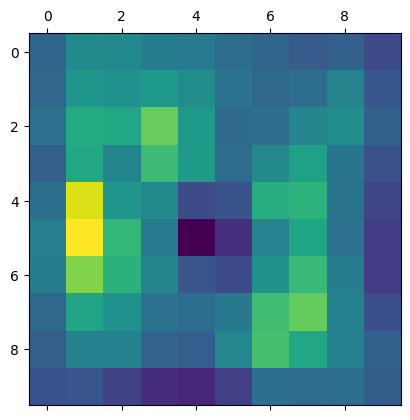

In [ ]:
# labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

img_path = '/content/Te-pi_0012.jpg'

# Load and preprocess image
img = Image.open(img_path)
resized_img = img.resize((299, 299))
img_array = np.asarray(resized_img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Make model
model = load_model('/content/xception_1_.keras')


# get predictions
predictions = model.predict(img_array)
print('predictions: ', predictions)
model.summary()

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(model, img_array)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
model: [[0.026589 0.4038283 0.34268376 0.22689892]]

model layers: <bound method Model.get_layer of <Functional name=functional, built=True>>

model last layer: <Activation name=block14_sepconv2_act, built=True>

model output: <KerasTensor shape=(None, 10, 10, 2048), dtype=float32, sparse=False, name=keras_tensor_273>



model: [[0.00358313 0.04324819 0.01663739 0.93653125]]

model layers: <bound method Model.get_layer of <Sequential name=sequential_1, built=True>>

model last layer: <Conv2D name=conv2d_11, built=True>

model output: <KerasTensor shape=(None, 28, 28, 64), dtype=float32, sparse=False, name=keras_tensor_44>

REMOVED LAST LAYER
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predicted: [0.9837127 3.476869  3.1185884 3.3896062]

UNREMOVED LAST LAYER
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Predicted: [0.03063375 0.37065017 0.25903884 0.3396772 ]

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
print('preprocess_input: ',)
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

img_path = '/content/Te-pi_0012.jpg'

# Load and preprocess image
img = Image.open(img_path)
resized_img = img.resize((224, 224))
img_array = np.asarray(resized_img)
img_array = np.expand_dims(img_array, axis=0) / 255.0


In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    print('model: ', model)
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    print('model inputs: ', model.inputs)
    print('last layer output: ', model.get_layer(last_conv_layer_name).output)
    print('model output: ', model.get_layer(last_conv_layer_name).output)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print('last_conv_layer_output: ', last_conv_layer_output.shape, " preds: ", preds.shape, type(preds[0]))
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        print('class_channel', class_channel)


    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print('grads: ', grads.shape)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    print('pooled_grads: ', pooled_grads.shape)

    last_conv_layer_output = last_conv_layer_output[0]
    print('last_conv_layer_output', last_conv_layer_output.shape)
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    print('heatmap: ', heatmap.shape)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted: [('n03868863', 'oxygen_mask', 6.563107)]
model:  <Functional name=xception, built=True>
model inputs:  [<KerasTensor shape=(None, 299, 299, 3), dtype=float32, sparse=None, name=keras_tensor_29586>]
last layer output:  <KerasTensor shape=(None, 10, 10, 2048), dtype=float32, sparse=False, name=keras_tensor_29717>
model output:  <KerasTensor shape=(None, 10, 10, 2048), dtype=float32, sparse=False, name=keras_tensor_29717>
last_conv_layer_output:  (1, 10, 10, 2048)  preds:  (1, 1000) <class 'tensorflow.python.framework.ops.EagerTensor'>
class_channel tf.Tensor([6.563109], shape=(1,), dtype=float32)
grads:  (1, 10, 10, 2048)
pooled_grads:  (2048,)
last_conv_layer_output (10, 10, 2048)
heatmap:  (10, 10)


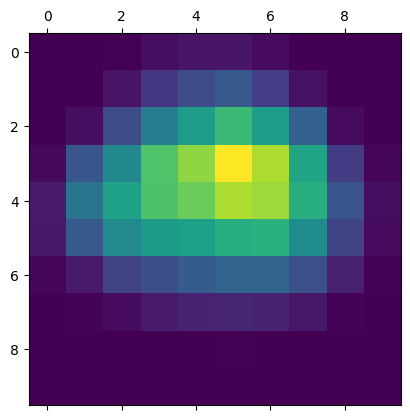

In [ ]:


# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()